In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Prophet for baseline model
from prophet import Prophet

# TensorFlow/Keras for LSTM model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Sklearn utilities
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

Importing plotly failed. Interactive plots will not work.


✓ All libraries imported successfully!


In [2]:
# ============================================================================
# SECTION 2: DATA LOADING AND PREPROCESSING
# ============================================================================


def load_and_prepare_data(file_path):
    """
    Load CSV data and prepare it for time series analysis

    Parameters:
        file_path: Path to the CSV file

    Returns:
        Prepared DataFrame with datetime index and PM2.5 values
    """
    print(f"\n📂 Loading data from: {file_path}")

    # Load the data
    df = pd.read_csv(file_path)

    # Display basic information
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {df.columns.tolist()}")

    # Select only required columns
    df = df[['From Date', 'To Date', 'PM2.5 (ug/m3)']].copy()

    # Convert date columns to datetime
    df['From Date'] = pd.to_datetime(df['From Date'])
    df['To Date'] = pd.to_datetime(df['To Date'])

    # Use 'To Date' as the primary date column
    df['Date'] = df['To Date']

    # Remove rows with missing PM2.5 values
    df = df.dropna(subset=['PM2.5 (ug/m3)'])

    # Sort by date
    df = df.sort_values('Date').reset_index(drop=True)

    print(f"   ✓ Data loaded: {len(df)} records")
    print(f"   Date range: {df['Date'].min()} to {df['Date'].max()}")

    return df


# Load your datasets (update paths as needed)
# For Kaggle datasets, first download them to your Colab environment

# Example for Maharashtra data
df_mh = load_and_prepare_data('MH015 (2).csv')

# Example for Delhi data (optional - you can combine or use separately)
# df_dl = load_and_prepare_data('/content/DL037.csv')

# Use one dataset for this example
df = df_mh.copy()


📂 Loading data from: MH015 (2).csv
   Shape: (7621, 23)
   Columns: ['From Date', 'To Date', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'Xylene (ug/m3)', 'AT (degree C)', 'RF (mm)']
   ✓ Data loaded: 7478 records
   Date range: 2019-06-20 14:00:00 to 2020-05-03 02:00:00



EXPLORATORY DATA ANALYSIS

📊 Statistical Summary:
count    7478.000000
mean       45.212077
std        36.797456
min         0.170000
25%        16.802500
50%        31.105000
75%        66.317500
max       313.200000
Name: PM2.5 (ug/m3), dtype: float64

🔍 Missing values: 0

🚨 Outlier Analysis:
Lower bound: -57.47
Upper bound: 140.59
Outliers count: 145
Outliers percentage: 1.94%


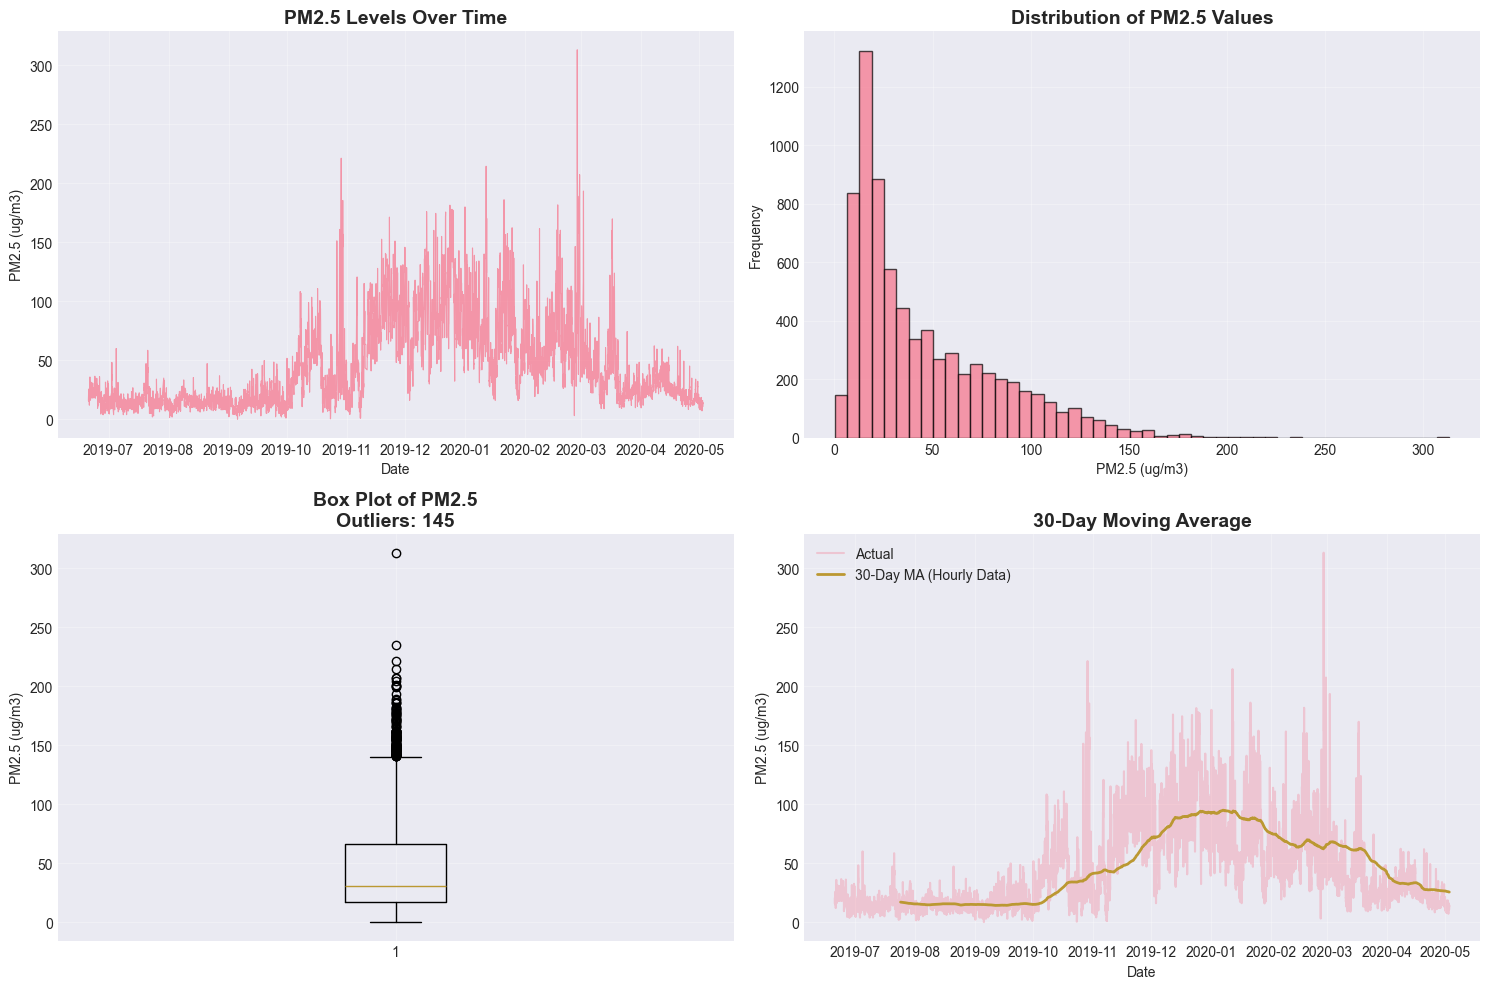


📌 EDA Conclusion:
• PM2.5 shows strong yearly seasonality with winter pollution peaks.
• Data is highly right-skewed with many extreme pollution events.
• Outliers are retained because they represent real-world pollution, not noise.
• Smoothing confirms long-term trend and seasonal cycles.


In [3]:
# ============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS (FINAL CLEAN VERSION)
# ============================================================================

print("\n" + "="*70)
print("EXPLORATORY DATA ANALYSIS")
print("="*70)

# ----------------------------
# 1. BASIC STATISTICS
# ----------------------------
print("\n📊 Statistical Summary:")
print(df['PM2.5 (ug/m3)'].describe())

# ----------------------------
# 2. MISSING VALUE CHECK
# ----------------------------
missing_count = df['PM2.5 (ug/m3)'].isna().sum()
print(f"\n🔍 Missing values: {missing_count}")

# ----------------------------
# 3. OUTLIER DETECTION (IQR METHOD)
# ----------------------------
Q1 = df['PM2.5 (ug/m3)'].quantile(0.25)
Q3 = df['PM2.5 (ug/m3)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['PM2.5 (ug/m3)'] < lower_bound) |
              (df['PM2.5 (ug/m3)'] > upper_bound)]

print("\n🚨 Outlier Analysis:")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Outliers count: {len(outliers)}")
print(f"Outliers percentage: {(len(outliers)/len(df))*100:.2f}%")

# ----------------------------
# 4. VISUALIZATION
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ---- (1) Time Series Plot ----
axes[0, 0].plot(df['Date'], df['PM2.5 (ug/m3)'], linewidth=0.8, alpha=0.7)
axes[0, 0].set_title('PM2.5 Levels Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('PM2.5 (ug/m3)')
axes[0, 0].grid(True, alpha=0.3)

# ---- (2) Distribution Plot ----
axes[0, 1].hist(df['PM2.5 (ug/m3)'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of PM2.5 Values', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('PM2.5 (ug/m3)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# ---- (3) Box Plot (Outliers) ----
axes[1, 0].boxplot(df['PM2.5 (ug/m3)'].dropna(), showfliers=True)
axes[1, 0].set_title(f'Box Plot of PM2.5\nOutliers: {len(outliers)}',
                     fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('PM2.5 (ug/m3)')
axes[1, 0].grid(True, alpha=0.3)

# ---- (4) Moving Average (30 days for hourly data) ----
ma_30 = df['PM2.5 (ug/m3)'].rolling(window=780).mean()  # 30 days × 26 hours

axes[1, 1].plot(df['Date'], df['PM2.5 (ug/m3)'], alpha=0.3, label='Actual')
axes[1, 1].plot(df['Date'], ma_30, linewidth=2, label='30-Day MA (Hourly Data)')
axes[1, 1].set_title('30-Day Moving Average', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('PM2.5 (ug/m3)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# 5. EDA CONCLUSION (IMPORTANT)
# ----------------------------
print("\n📌 EDA Conclusion:")
print("• PM2.5 shows strong yearly seasonality with winter pollution peaks.")
print("• Data is highly right-skewed with many extreme pollution events.")
print("• Outliers are retained because they represent real-world pollution, not noise.")
print("• Smoothing confirms long-term trend and seasonal cycles.")


In [4]:
#============================================================================
# SECTION 4: DATA SPLITTING
# ============================================================================

print("\n" + "="*70)
print("DATA PREPARATION")
print("="*70)

# Define train-test split ratio
train_ratio = 0.8
split_index = int(len(df) * train_ratio)

# Split the data
train_data = df.iloc[:split_index].copy()
test_data = df.iloc[split_index:].copy()

print(f"\n📊 Dataset Split:")
print(f"   Training set: {len(train_data)} records ({train_ratio*100:.0f}%)")
print(f"   Testing set: {len(test_data)} records ({(1-train_ratio)*100:.0f}%)")
print(f"   Train date range: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"   Test date range: {test_data['Date'].min()} to {test_data['Date'].max()}")




DATA PREPARATION

📊 Dataset Split:
   Training set: 5982 records (80%)
   Testing set: 1496 records (20%)
   Train date range: 2019-06-20 14:00:00 to 2020-03-01 17:00:00
   Test date range: 2020-03-01 18:00:00 to 2020-05-03 02:00:00



BASELINE MODEL: FACEBOOK PROPHET

🔮 Training Prophet model...


22:04:01 - cmdstanpy - INFO - Chain [1] start processing
22:04:04 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet trained successfully

📊 Prophet Performance:
MAE:  3355.27


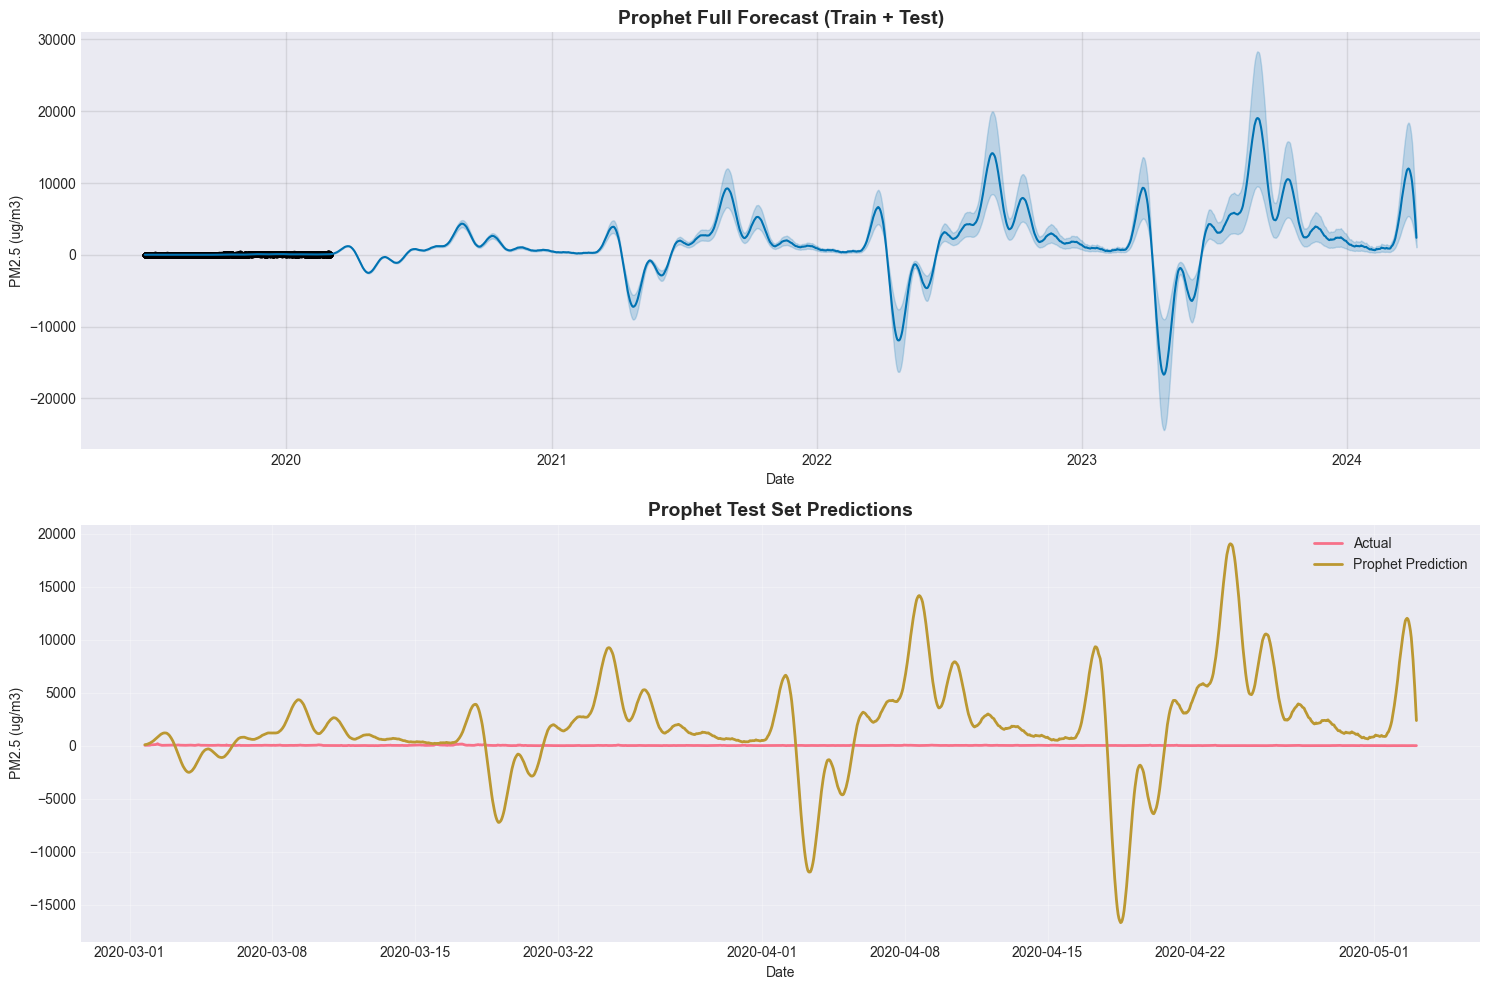

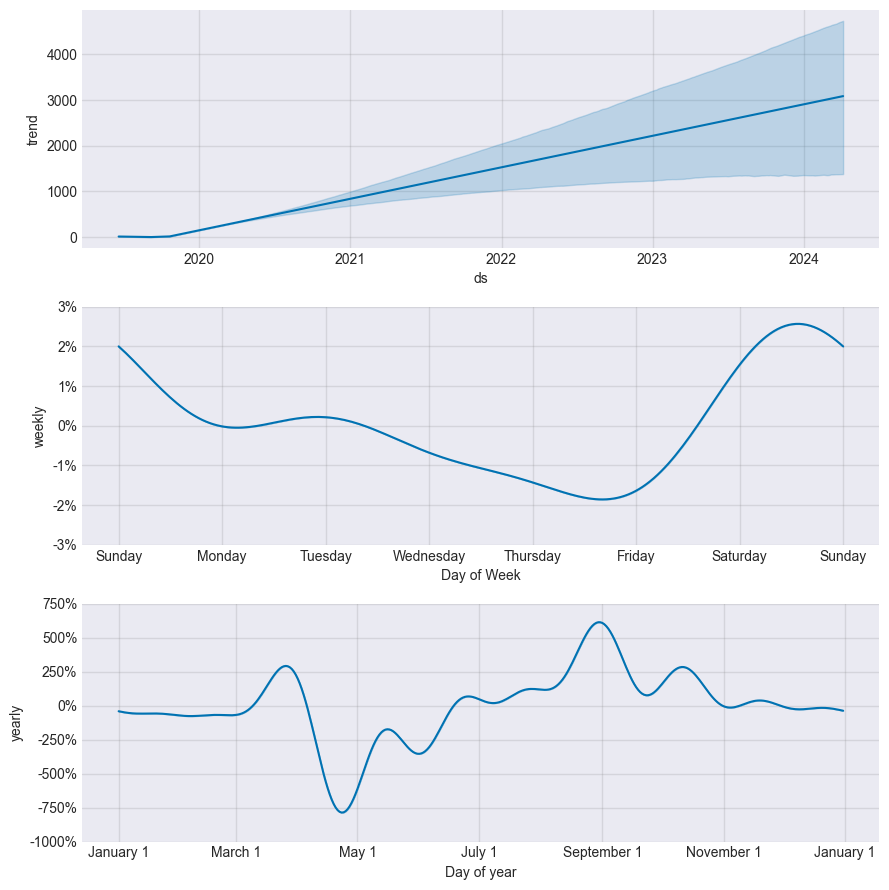

In [5]:
# ============================================================================
# SECTION 5: BASELINE MODEL - FACEBOOK PROPHET (FINAL CLEAN VERSION)
# ============================================================================

print("\n" + "="*70)
print("BASELINE MODEL: FACEBOOK PROPHET")
print("="*70)

# -------------------------------
# Prepare data
# -------------------------------
prophet_train = train_data[['Date', 'PM2.5 (ug/m3)']].copy()
prophet_train.columns = ['ds', 'y']

# -------------------------------
# Build & train model
# -------------------------------
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative'
)

print("\n🔮 Training Prophet model...")
prophet_model.fit(prophet_train)
print("✓ Prophet trained successfully")

# -------------------------------
# Forecast future
# -------------------------------
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast = prophet_model.predict(future)

# -------------------------------
# Correct slicing (date-based)
# -------------------------------
test_predictions = forecast[
    forecast['ds'] >= test_data['Date'].min()
]['yhat'].values

test_actual = test_data['PM2.5 (ug/m3)'].values

# -------------------------------
# Metrics
# -------------------------------
# rmse_prophet = np.sqrt(mean_squared_error(test_actual, test_predictions))
mae_prophet = mean_absolute_error(test_actual, test_predictions)
# r2_prophet = r2_score(test_actual, test_predictions)

print(f"\n📊 Prophet Performance:")
# print(f"RMSE: {rmse_prophet:.2f}")
print(f"MAE:  {mae_prophet:.2f}")
# print(f"R²:   {r2_prophet:.4f}")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# -------------------------------
# 1. Full Forecast (Train + Test)
# -------------------------------
prophet_model.plot(forecast, ax=axes[0])
axes[0].set_title('Prophet Full Forecast (Train + Test)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('PM2.5 (ug/m3)')

# -------------------------------
# 2. Test Set Comparison
# -------------------------------
axes[1].plot(test_data['Date'], test_actual, label='Actual', linewidth=2)
axes[1].plot(test_data['Date'], test_predictions, label='Prophet Prediction', linewidth=2)

axes[1].set_title('Prophet Test Set Predictions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('PM2.5 (ug/m3)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------------
# Prophet Components (VERY IMPORTANT)
# -------------------------------
prophet_model.plot_components(forecast)
plt.show()



PROPOSED MODEL: LSTM

🔄 Creating sequences with lookback = 60
   Training sequences: (5922, 60, 1)
   Testing sequences: (1436, 60, 1)

🧠 Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training LSTM model...
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0047 - mae: 0.0449 - val_loss: 0.0098 - val_mae: 0.0763 - learning_rate: 0.0010
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0033 - mae: 0.0374 - val_loss: 0.0056 - val_mae: 0.0550 - learning_rate: 0.0010
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0025 - mae: 0.0333 - val_loss: 0.0048 - val_mae: 0.0510 - learning_rate: 0.0010
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0022 - mae: 0.0318 - val_loss: 0.0043 - val_mae: 0.0471 - learning_rate: 0.0010
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0020 - mae: 0.0300 - val_loss: 0.0039 - val_mae: 0.0441 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
   ✓ Model trained successfully!

🔮 Making predictions...
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📈 LSTM Model Performance:
   RMSE: 8.76
   MAE:  6.10
   R² Score: 0.7573


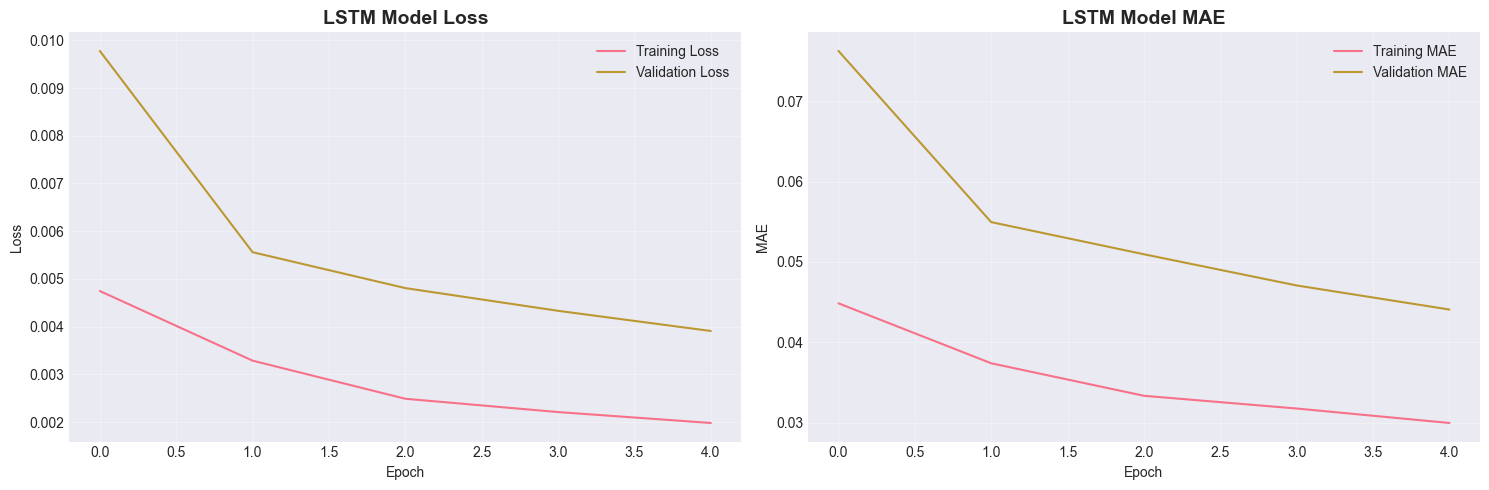

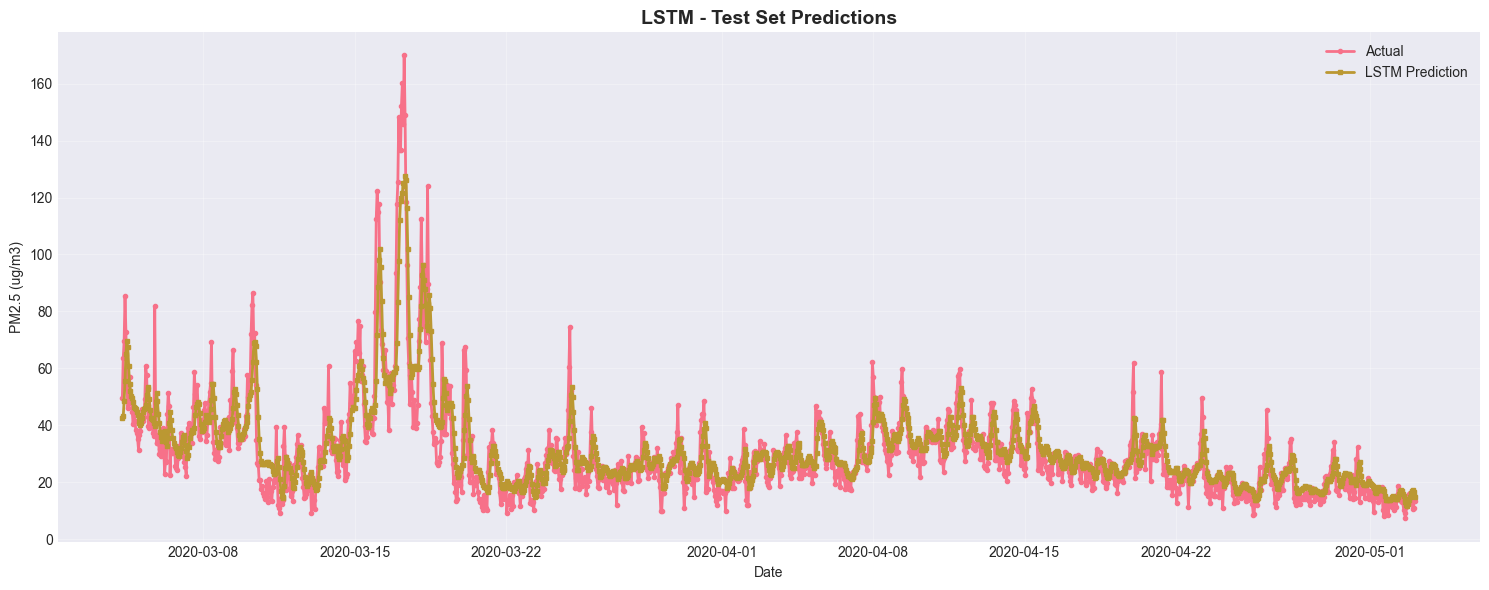

In [6]:
 #============================================================================
# SECTION 6: PROPOSED MODEL - LSTM
# ============================================================================

print("\n" + "="*70)
print("PROPOSED MODEL: LSTM")
print("="*70)

# Prepare data for LSTM
def create_sequences(data, lookback=60):
    """
    Create sequences for LSTM training

    Parameters:
        data: Array of PM2.5 values
        lookback: Number of previous time steps to use

    Returns:
        X, y arrays for training
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(data[i])
    return np.array(X), np.array(y)


# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[['PM2.5 (ug/m3)']].values)
scaled_test = scaler.transform(test_data[['PM2.5 (ug/m3)']].values)

# Create sequences
lookback = 60  # Use past 60 time steps
print(f"\n🔄 Creating sequences with lookback = {lookback}")

X_train, y_train = create_sequences(scaled_train, lookback)
X_test, y_test = create_sequences(scaled_test, lookback)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"   Training sequences: {X_train.shape}")
print(f"   Testing sequences: {X_test.shape}")

# Build LSTM model
print("\n🧠 Building LSTM model...")
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),

    LSTM(units=50, return_sequences=True),
    Dropout(0.2),

    LSTM(units=50, return_sequences=False),
    Dropout(0.2),

    Dense(units=25),
    Dense(units=1)
])

# Compile the model
lstm_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

print(lstm_model.summary())

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("\n🚀 Training LSTM model...")
history = lstm_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("   ✓ Model trained successfully!")

# Make predictions
print("\n🔮 Making predictions...")
lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_actual, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_actual, lstm_predictions)
r2_lstm = r2_score(y_test_actual, lstm_predictions)

print(f"\n📈 LSTM Model Performance:")
print(f"   RMSE: {rmse_lstm:.2f}")
print(f"   MAE:  {mae_lstm:.2f}")
print(f"   R² Score: {r2_lstm:.4f}")

# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('LSTM Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('LSTM Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize LSTM predictions
test_dates_lstm = test_data['Date'].iloc[lookback:].values

plt.figure(figsize=(15, 6))
plt.plot(test_dates_lstm, y_test_actual, label='Actual', linewidth=2, marker='o', markersize=3)
plt.plot(test_dates_lstm, lstm_predictions, label='LSTM Prediction', linewidth=2, marker='s', markersize=3)
plt.title('LSTM - Test Set Predictions', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m3)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



ENHANCED MODEL: XGBOOST

🔧 Creating features for XGBoost...
   ✓ Created 31 features
   Features: ['year', 'month', 'day', 'dayofweek', 'quarter', 'dayofyear', 'weekofyear', 'month_sin', 'month_cos', 'dayofweek_sin']...

   Training samples: (5952, 31)
   Testing samples: (1466, 31)

🌳 Training XGBoost model...
[0]	validation_0-rmse:38.89792	validation_1-rmse:25.21686
[50]	validation_0-rmse:24.69498	validation_1-rmse:16.03747
[100]	validation_0-rmse:16.15317	validation_1-rmse:10.68685
[150]	validation_0-rmse:11.09474	validation_1-rmse:7.68032
[200]	validation_0-rmse:8.09438	validation_1-rmse:6.05188
[250]	validation_0-rmse:6.33239	validation_1-rmse:5.22169
[300]	validation_0-rmse:5.32131	validation_1-rmse:4.82231
[350]	validation_0-rmse:4.69722	validation_1-rmse:4.60019
[400]	validation_0-rmse:4.28892	validation_1-rmse:4.46779
[450]	validation_0-rmse:3.99998	validation_1-rmse:4.38526
[500]	validation_0-rmse:3.75415	validation_1-rmse:4.32348
[550]	validation_0-rmse:3.55963	validation_1

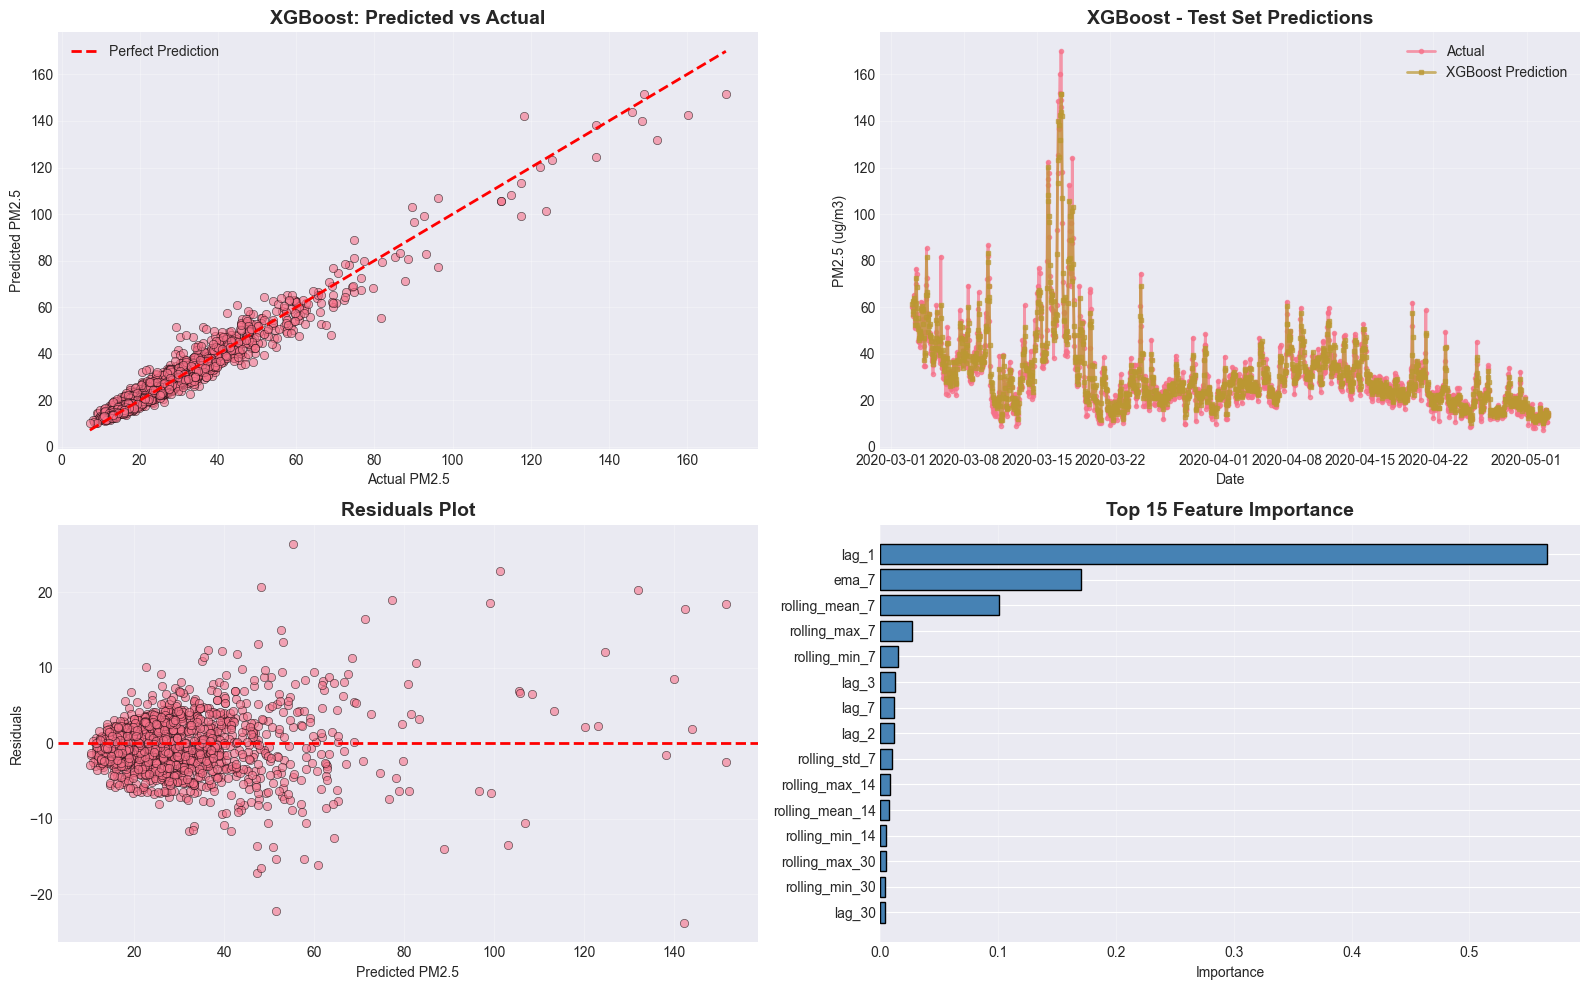

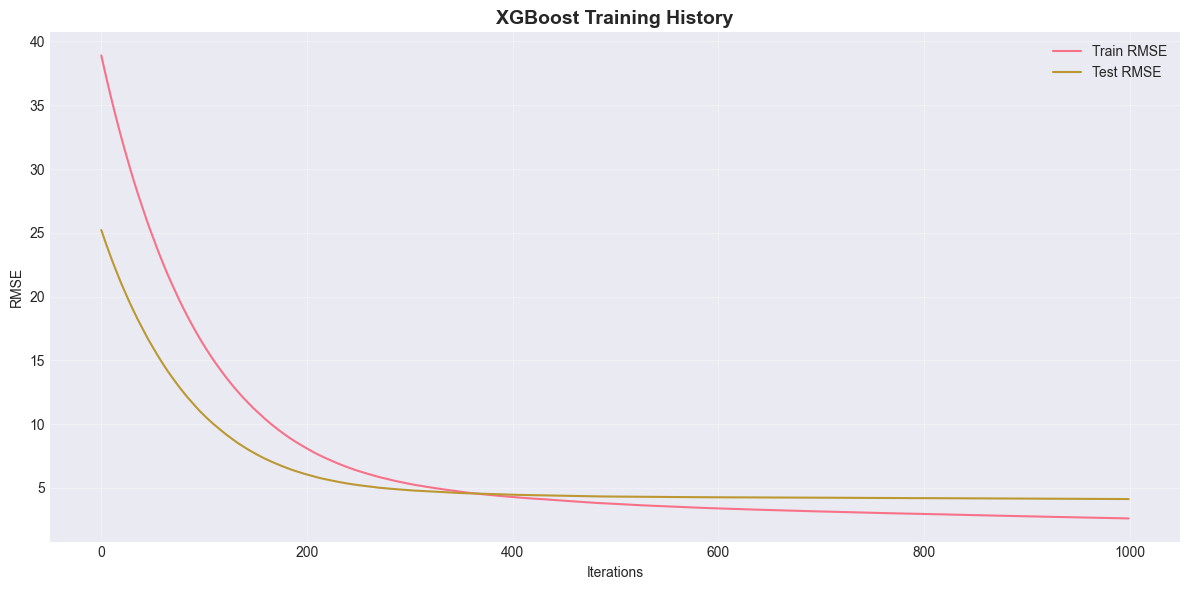

In [7]:
# ============================================================================
# SECTION 8: MODEL COMPARISON (ALL THREE MODELS)
# ============================================================================
print("\n" + "="*70)
print("ENHANCED MODEL: XGBOOST")
print("="*70)

# Install XGBoost if needed
try:
    import xgboost as xgb
except ImportError:
    print("Installing XGBoost...")
    !pip install xgboost
    import xgboost as xgb

# Feature Engineering for XGBoost
def create_features(data, lag_features=True):
    """
    Create time-based and lag features for XGBoost

    Parameters:
        data: DataFrame with Date and PM2.5 columns
        lag_features: Whether to create lag features

    Returns:
        DataFrame with engineered features
    """
    df = data.copy()

    # Time-based features
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.isocalendar().week

    # Cyclical encoding for month and day of week
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    if lag_features:
        # Lag features (previous values)
        for lag in [1, 2, 3, 7, 14, 30]:
            df[f'lag_{lag}'] = df['PM2.5 (ug/m3)'].shift(lag)

        # Rolling statistics
        for window in [7, 14, 30]:
            df[f'rolling_mean_{window}'] = df['PM2.5 (ug/m3)'].rolling(window=window).mean()
            df[f'rolling_std_{window}'] = df['PM2.5 (ug/m3)'].rolling(window=window).std()
            df[f'rolling_min_{window}'] = df['PM2.5 (ug/m3)'].rolling(window=window).min()
            df[f'rolling_max_{window}'] = df['PM2.5 (ug/m3)'].rolling(window=window).max()

        # Exponential moving average
        df['ema_7'] = df['PM2.5 (ug/m3)'].ewm(span=7, adjust=False).mean()
        df['ema_30'] = df['PM2.5 (ug/m3)'].ewm(span=30, adjust=False).mean()

    return df

print("\n🔧 Creating features for XGBoost...")

# Create features for train and test data
train_features = create_features(train_data, lag_features=True)
test_features = create_features(test_data, lag_features=True)

# Drop rows with NaN values (created by lag/rolling features)
train_features = train_features.dropna()
test_features = test_features.dropna()

# Prepare feature columns
feature_columns = [col for col in train_features.columns
                   if col not in ['Date', 'From Date', 'To Date', 'PM2.5 (ug/m3)', 'MA_30']]

print(f"   ✓ Created {len(feature_columns)} features")
print(f"   Features: {feature_columns[:10]}...")  # Show first 10 features

# Prepare X and y
X_train_xgb = train_features[feature_columns]
y_train_xgb = train_features['PM2.5 (ug/m3)']
X_test_xgb = test_features[feature_columns]
y_test_xgb = test_features['PM2.5 (ug/m3)']

print(f"\n   Training samples: {X_train_xgb.shape}")
print(f"   Testing samples: {X_test_xgb.shape}")

# Build and train XGBoost model
print("\n🌳 Training XGBoost model...")

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

# Train with validation set
eval_set = [(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)]
xgb_model.fit(
    X_train_xgb,
    y_train_xgb,
    eval_set=eval_set,
    verbose=50
)

print("   ✓ Model trained successfully!")

# Make predictions
print("\n🔮 Making predictions with XGBoost...")
xgb_predictions = xgb_model.predict(X_test_xgb)

# Calculate metrics for XGBoost
mse_xgb = mean_squared_error(y_test_xgb, xgb_predictions)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, xgb_predictions)
r2_xgb = r2_score(y_test_xgb, xgb_predictions)

print(f"\n📈 XGBoost Model Performance:")
print(f"   RMSE: {rmse_xgb:.2f}")
print(f"   MAE:  {mae_xgb:.2f}")
print(f"   R² Score: {r2_xgb:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n🔝 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize XGBoost results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Predictions vs Actual
axes[0, 0].scatter(y_test_xgb, xgb_predictions, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0, 0].plot([y_test_xgb.min(), y_test_xgb.max()],
                [y_test_xgb.min(), y_test_xgb.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_title('XGBoost: Predicted vs Actual', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Actual PM2.5')
axes[0, 0].set_ylabel('Predicted PM2.5')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Time series comparison
test_dates_xgb = test_features['Date'].values
axes[0, 1].plot(test_dates_xgb, y_test_xgb.values, label='Actual', linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[0, 1].plot(test_dates_xgb, xgb_predictions, label='XGBoost Prediction', linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[0, 1].set_title('XGBoost - Test Set Predictions', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('PM2.5 (ug/m3)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test_xgb.values - xgb_predictions
axes[1, 0].scatter(xgb_predictions, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residuals Plot', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted PM2.5')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Feature importance (top 15)
top_features = feature_importance.head(15)
axes[1, 1].barh(top_features['Feature'], top_features['Importance'], color='steelblue', edgecolor='black')
axes[1, 1].set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Training history plot
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test RMSE')
ax.set_title('XGBoost Training History', fontsize=14, fontweight='bold')
ax.set_xlabel('Iterations')
ax.set_ylabel('RMSE')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
import requests

OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL = "qwen3:4b"

def call_ollama(prompt):
    response = requests.post(
        OLLAMA_URL,
        json={
            "model": MODEL,
            "prompt": prompt,
            "stream": False
        },
        timeout=300
    )
    return response.json()["response"]


In [9]:
def pm25_to_aqi_category(pm25):
    if pm25 <= 30:
        return "Good"
    elif pm25 <= 60:
        return "Satisfactory"
    elif pm25 <= 90:
        return "Moderate"
    elif pm25 <= 120:
        return "Poor"
    elif pm25 <= 250:
        return "Very Poor"
    else:
        return "Severe"


In [10]:
def build_xgb_future_prompt(date, pm25, aqi_category):
    return f"""
ROLE:
You are an environmental health advisory assistant.

CONTEXT:
The following air quality values are predicted for a future date.

FORECAST DATA:
Date: {date}
Predicted PM2.5: {pm25:.2f} µg/m³
Expected AQI Category: {aqi_category}

TASK:
Explain the expected air quality condition.
Describe possible health impacts.
Suggest preventive actions people can take in advance.

CONSTRAINTS:
- Treat this strictly as a forecast
- Do not mention machine learning or models
- Do not invent additional data
- Use simple public-friendly language
- Limit response to under 100 words

OUTPUT FORMAT:
1. Expected Air Quality
2. Health Impact
3. Precautions
"""


In [11]:
print("\n🔮 XGBoost Forecast + LLM Advisory (Demo)\n")

for i in range(3):  # demo first 3 future predictions
    pm25 = float(xgb_predictions[i])
    date = test_dates_xgb[i]
    aqi_category = pm25_to_aqi_category(pm25)

    prompt = build_xgb_future_prompt(date, pm25, aqi_category)
    explanation = call_ollama(prompt)

    print(f"📅 Forecast Date: {date}")
    print(f"Predicted PM2.5: {pm25:.2f} µg/m³")
    print("LLM Advisory:")
    print(explanation)
    print("-" * 60)



🔮 XGBoost Forecast + LLM Advisory (Demo)



KeyError: 'response'